## ThyrosimIM 
Adding an immune submodel to p-Thyrosim to simulate Hashimoto's thyroiditis. Before running, make sure to open REPL and `activate thyrosimIM` in pkg mode. Otherwise you can get some weird behavior where empty cells will run forever.

In [1]:
# Note that each cell will take quite a while to run the first time
using DifferentialEquations
using Plots

In [2]:
# Import files from src folder
include("thyrosim_IM_odes.jl")
include("utils.jl");

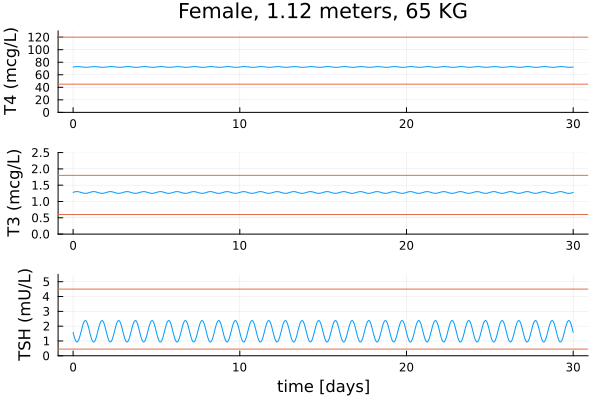

In [3]:
sex = false
h = 1.12
w = 65
sol = simulate(h,w,sex)
plt = output_plot(sol, title="Female, $h meters, $w KG")